In [63]:
from dataset_util import platedataset
import random
from PIL import Image

In [111]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = "True"

In [10]:
from torchvision.transforms import ToTensor

In [5]:
labels_map = {1:"license"}

In [6]:
def extract_number(filename):
    return int("".join(list(filter(lambda x:x.isdigit(), filename))))

In [8]:
def show_grid_samples(dataset, class_map=labels_map, start=0, indices=None):
    num_images = 16
    grid_size = 4

    if indices is None:
        indices = list(range(start,start+16))


    fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        image, target = dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()

        ax.imshow(image_np)
        ax.axis('off')

        for box, label in zip(target['boxes'], target['labels']):
            xmin, ymin, xmax, ymax = box.tolist()
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height,
                                     linewidth=1.5, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            label_str = class_map.get(label.item(), f'class_{label.item()}')
            ax.text(xmin, ymin - 3, label_str, color='white', fontsize=8,
                    bbox=dict(facecolor='black', alpha=0.5, pad=1))

        ax.set_title(f"#{idx}", fontsize=10)

    plt.tight_layout()
    plt.suptitle("Datset Images")   
    plt.show()

In [11]:
dataset = platedataset(root = "datasets", transforms = ToTensor())

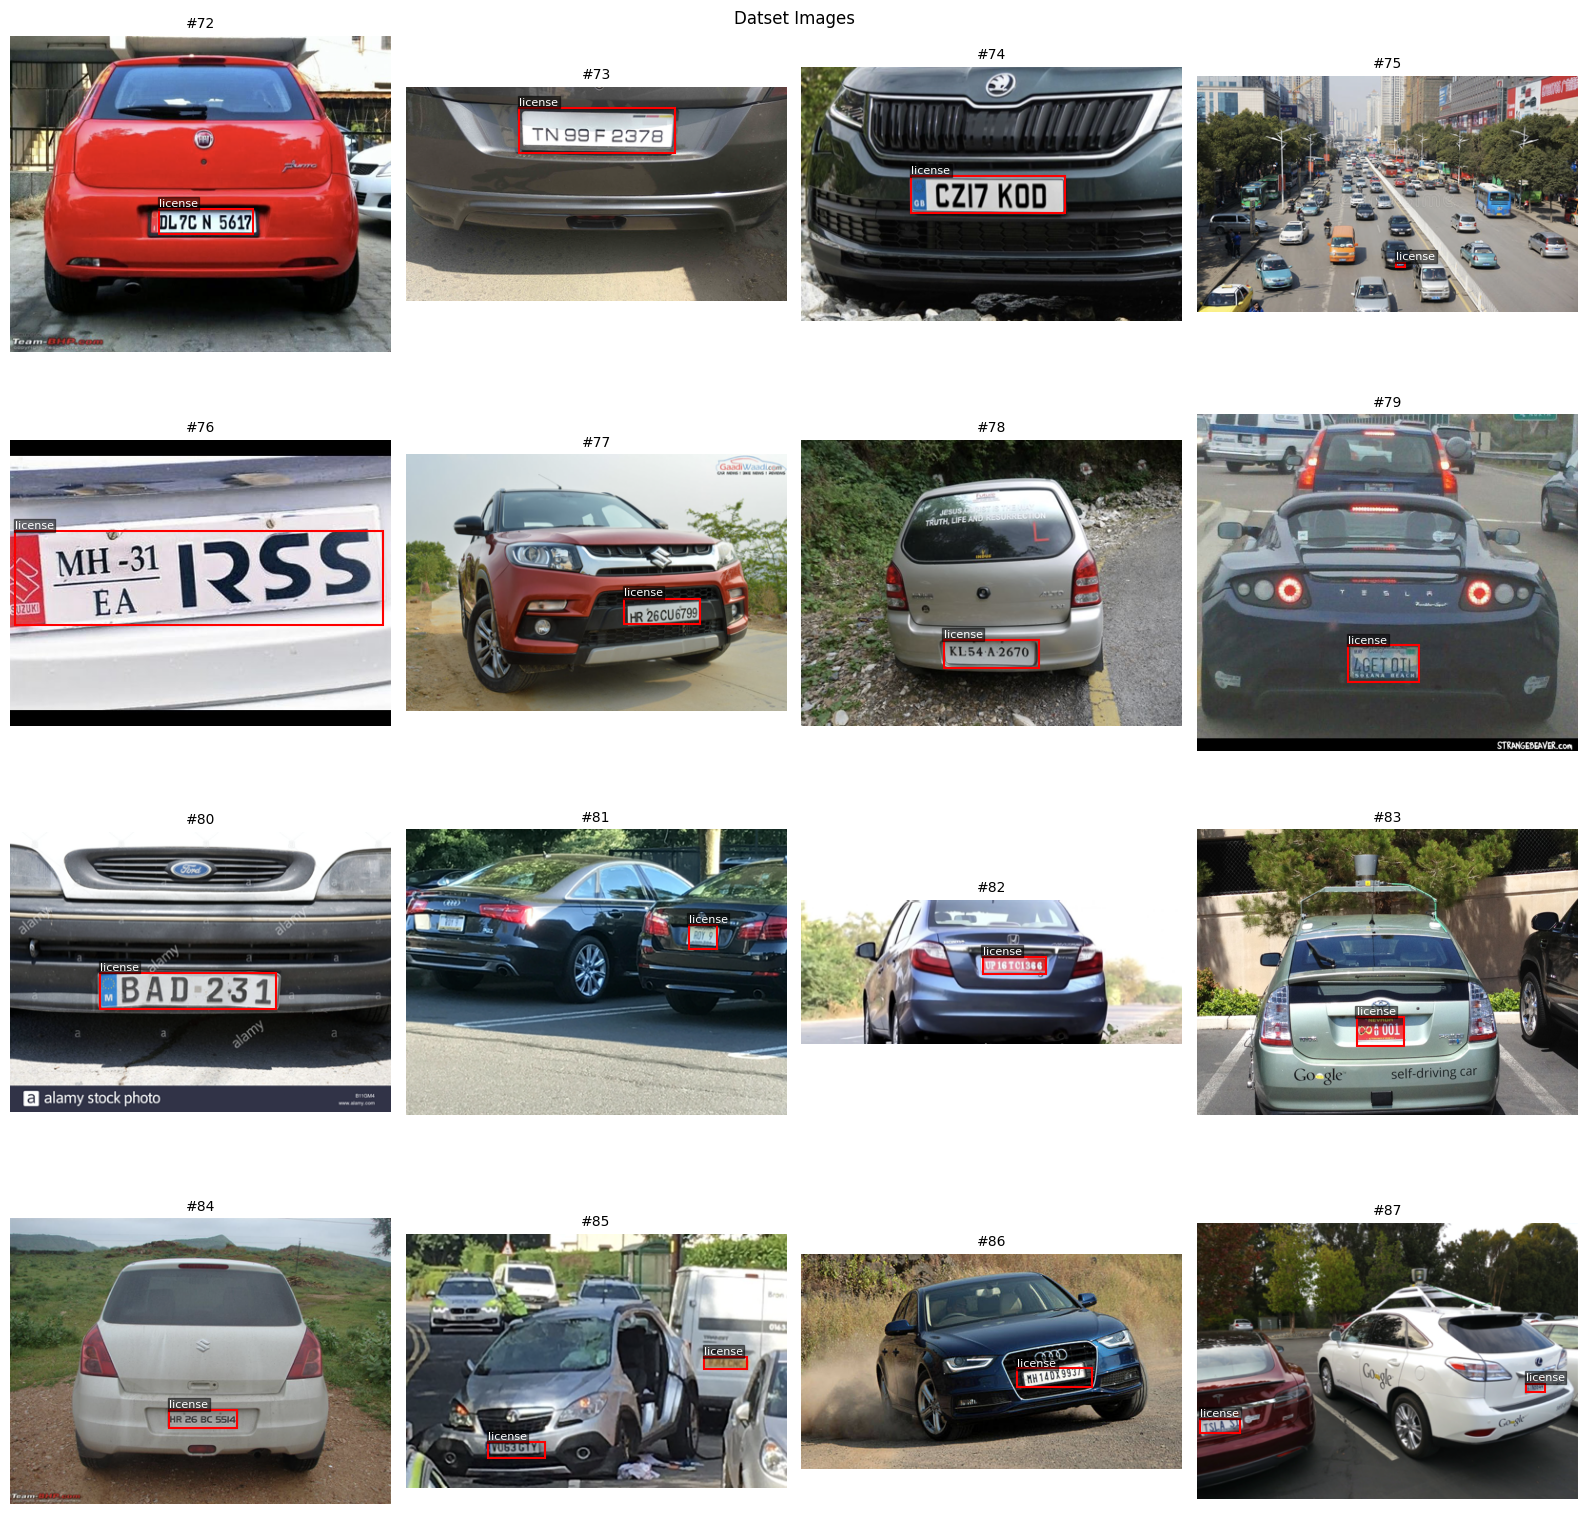

In [10]:
show_grid_samples(dataset,start=72)

In [1]:
from train import get_model

In [10]:
model = get_model(2)

In [4]:
for name, module in model.named_children():
    print(name)

transform
backbone
rpn
roi_heads


In [18]:
frozen = sum(not p.requires_grad for p in model.parameters())
total = sum(1 for _ in model.parameters())

In [19]:
frozen

69

In [20]:
total

83

In [41]:
dataset[89][1]

{'boxes': tensor([[307., 206., 345., 221.],
         [227., 222., 253., 230.]]),
 'labels': tensor([1, 1]),
 'image_id': tensor([89]),
 'area': tensor([570., 208.]),
 'iscrowd': tensor([0, 0])}

In [1]:
import torch
import torchvision

In [2]:
print(torch.cuda.is_available())  # should be True
# print(torchvision._C._is_tracing())  # just to sanity check internalsa

True


In [3]:
from torchvision.ops import nms

In [4]:
boxes = torch.tensor([[0, 0, 100, 100], [10, 10, 110, 110]], dtype=torch.float32).cuda()
scores = torch.tensor([0.95, 0.9], dtype=torch.float32).cuda()

print("NMS output:", nms(boxes, scores, 0.5))  # should run without error

NMS output: tensor([0], device='cuda:0')


In [5]:
from train import get_dataloaders, get_model

In [7]:
model = get_model(num_classes=2).to(device="cuda")

In [12]:
train, val = get_dataloaders(dataset=dataset, batch_size=8)

In [21]:
model.eval()
with torch.no_grad():
    for images, targets in val:
        images = [img.to("cuda") for img in images]
        targets = [{k: v.to("cuda") for k, v in t.items()} for t in targets]
        # print(images[0].shape)
        # print(targets[0])
        output = model(images, targets)
        break

In [24]:
len(output)

8

In [27]:
output[0]["boxes"].shape

torch.Size([100, 4])

In [28]:
a, b = dataset[0]

In [39]:
type(b)

dict

In [34]:
b

{'boxes': tensor([[226., 125., 419., 173.]]),
 'labels': tensor([1]),
 'image_id': tensor([0]),
 'area': tensor([9264.]),
 'iscrowd': tensor([0])}

In [49]:
model.roi_heads.detections_per_img = 1
model.eval()
with torch.no_grad():
    images = [a.to("cuda")]
    targets = [{k: v.to("cuda") for k, v in b.items()}]
    # print(images)
    output1 = model(images, targets)

In [50]:
output1

[{'boxes': tensor([[304.1256,  84.0399, 341.8003, 107.1711]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9367], device='cuda:0')}]

In [48]:
output1[0]["boxes"].shape

torch.Size([100, 4])

In [51]:
# model.roi_heads.detections_per_img = 1
model.train()
with torch.no_grad():
    images = [a.to("cuda")]
    targets = [{k: v.to("cuda") for k, v in b.items()}]
    # print(images)
    output2 = model(images, targets)

In [52]:
output2

{'loss_classifier': tensor(1.3798, device='cuda:0'),
 'loss_box_reg': tensor(0.0382, device='cuda:0'),
 'loss_objectness': tensor(0.0129, device='cuda:0'),
 'loss_rpn_box_reg': tensor(0.0197, device='cuda:0')}

In [53]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [57]:
train_losses = [0.178, 0.111, 0.096, 0.09, 0.083, 0.073, 0.07, 0.067, 0.065, 0.065]
val_losses = [0.12, 0.102, 0.103, 0.0935, 0.093, 0.0868, 0.0847, 0.0837, 0.0849, 0.0831]
epochs = list(range(1,11))

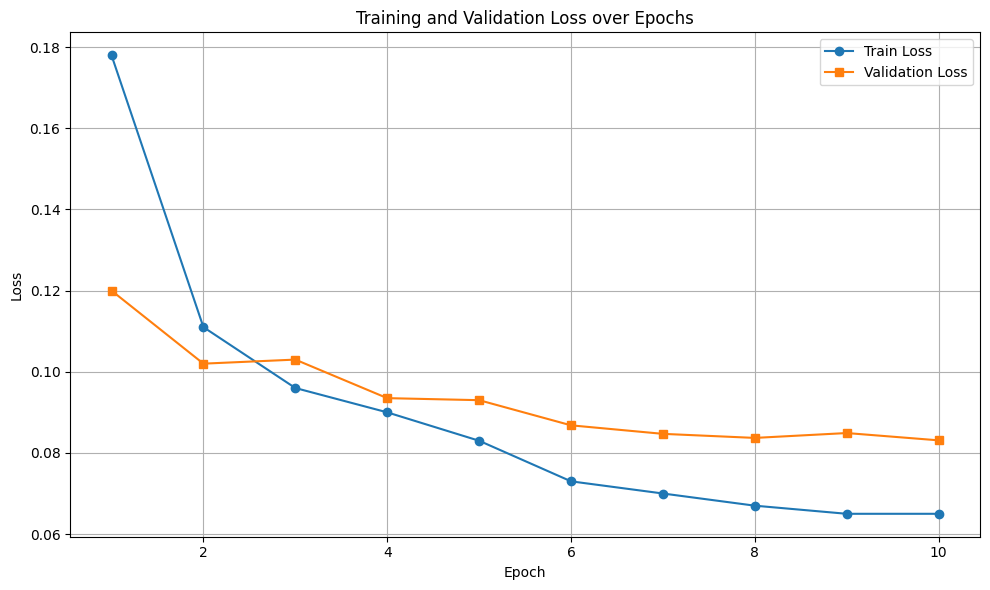

In [58]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='s', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
trained_model = torch.load("train/checkpoint_2025-07-07_19-56-37/best.pth", weights_only=False)

In [118]:
import numpy as np
import xml.etree.ElementTree as et

In [159]:
def visualize_pred(model, img_path, device="cuda", annot_path=None):

    model.roi_heads.detections_per_img = 1
    model.eval()

    img = Image.open(img_path)
    
    if img.size[0] > 600 or img.size[1] > 600:

        img = img.resize((400,267), 1)
    
    img = img.convert("RGB")
    transform = ToTensor()
    
    with torch.no_grad():
        img_tensor = [transform(img).to(device)]
        pred = model(img_tensor)[0]["boxes"].cpu().numpy()

        print(pred)

    fig, ax = plt.subplots(1, figsize=(10,6))
    ax.imshow(img)

    for bbox in pred:
        
        x1, y1, x2, y2 = bbox.astype(int).round()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"Pred", color='white',
                    fontsize=10, backgroundcolor="red")
    
    if annot_path:

        tree = et.parse(annot_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            
            bndbox = obj.find("bndbox")
            x1_ = int(bndbox.find("xmin").text)
            y1_ = int(bndbox.find("ymin").text)
            x2_ = int(bndbox.find("xmax").text)
            y2_ = int(bndbox.find("ymax").text)

            rect2 = patches.Rectangle((x1_, y1_), x2_ - x1_, y2_ - y1_, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect2)
            ax.text(x2_+3, y2_+5, f"gt", color='white', fontsize=10, backgroundcolor="green")
    
    plt.axis('off')
    plt.title("Prediction")
    plt.show()    

[[162.84853  98.18877 238.62875 130.0573 ]]


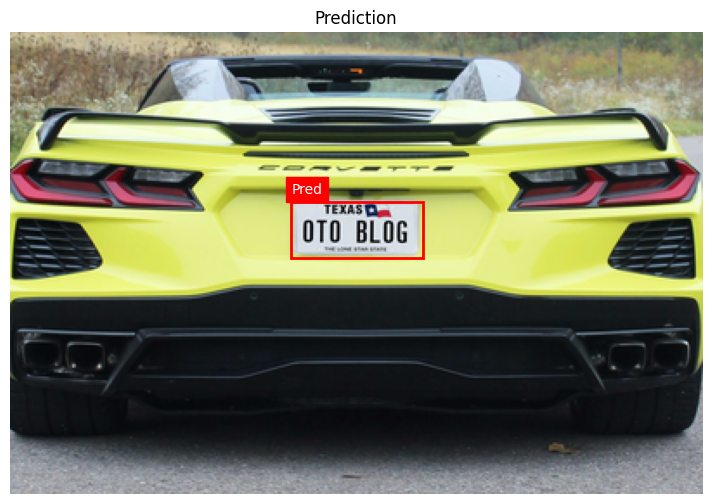

In [161]:
visualize_pred(model=trained_model, img_path=r"test_images/one.png")

In [148]:
tst_img = Image.open("test_images/one.png")

In [153]:
tst_img = tst_img.resize((400,267), 0)

In [156]:
tst_img.size

(400, 267)